# Lesson 6: Essay Writer

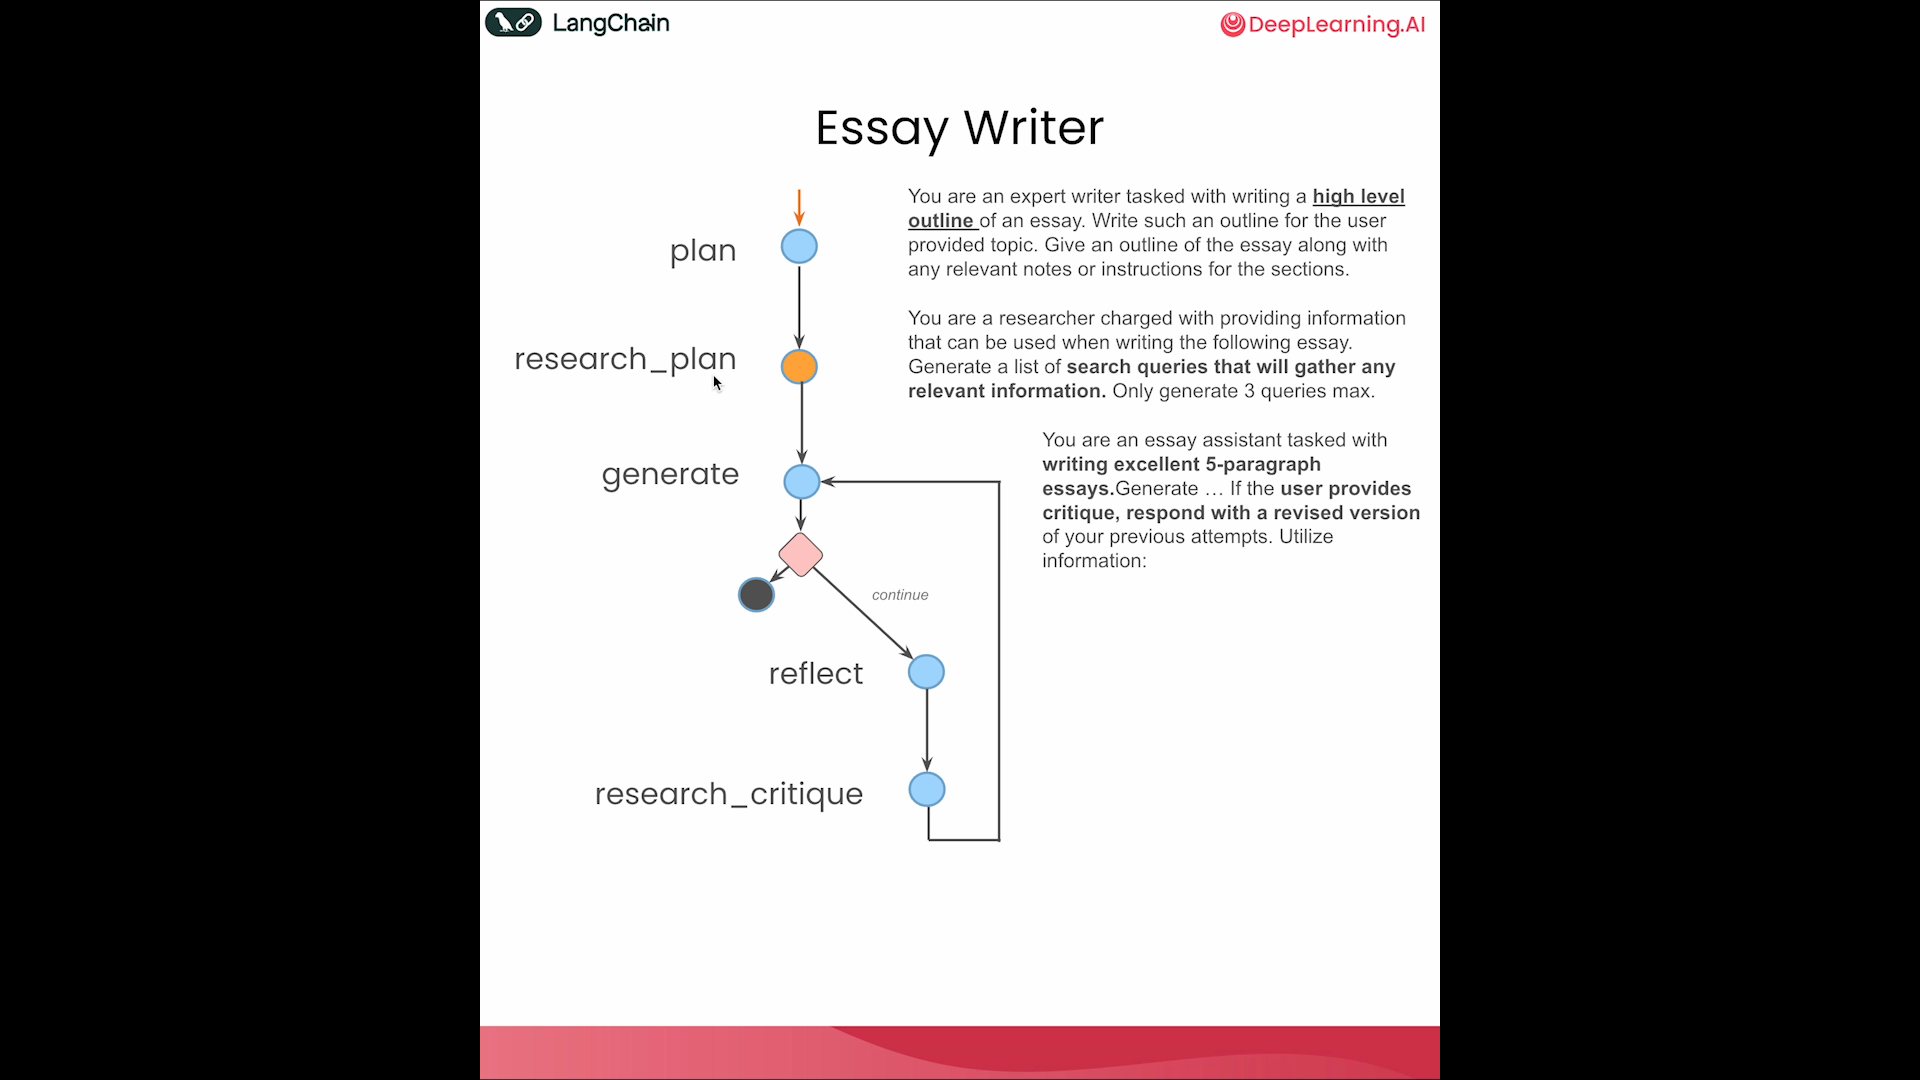

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    task: str  ## Human Input 
    plan: str  ## Plan that planning agent will generate
    draft: str  ## Draft of essay
    critique: str 
    content: List[str]  ## List of documents that Travily has researched 
    revision_number: int  ## Number of revisions 
    max_revisions: int  ## When to stop

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

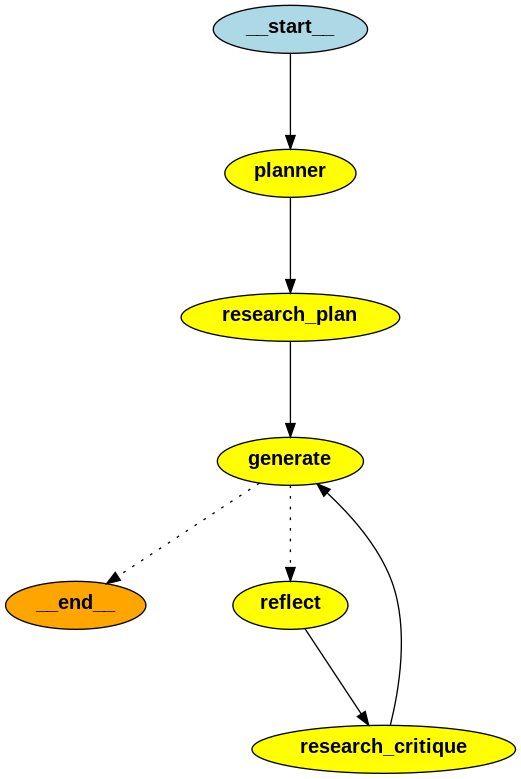

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Interoperability\n    E. Performance\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for the future of blockchain technology\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure to provide clear definitions and explanations of both Langchain and Langsmith.\n- Include specific examples of real-world application

{'research_critique': {'content': ['This report aims to provide a detailed analysis of the difference between LangChain and LangSmith based on the information available from various sources. ## LangChain: A Language Model Software Tool for Prototyping LangChain is a language model software tool that is primarily focused on helping developers build prototypes. It provides a ...', 'This guide offers an in-depth look into the essential features and functionalities of Langsmith. Understanding Langsmith vs Langchain. Prior to exploring Langsmith, it is crucial to differentiate between Langsmith and Langchain. While Langchain is mainly used for prototyping, Langsmith is designed to tackle challenges at the production level.', 'Langchain vs Langsmith: Unpacking the AI Language Model Showdown\nOverview of Langchain and Langsmith\nLangchain is a versatile open-source framework that enables you to build applications utilizing large language models (LLM) like GPT-3. Check out our free WhatsApp ch

## Essay Writer Interface

In [27]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [28]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://0.0.0.0:8080
Running on public URL: https://73e6af7acf5ca0e5f3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
